In [ ]:
!pip install transformers

In [ ]:
import cv2
import os

import numpy as np
import torch
import matplotlib.pyplot as plt

In [ ]:

from transformers import Blip2Processor, Blip2ForConditionalGeneration

In [4]:
import sys
sys.path.append("/home/arafat/projects/flow_matching_and_llm")

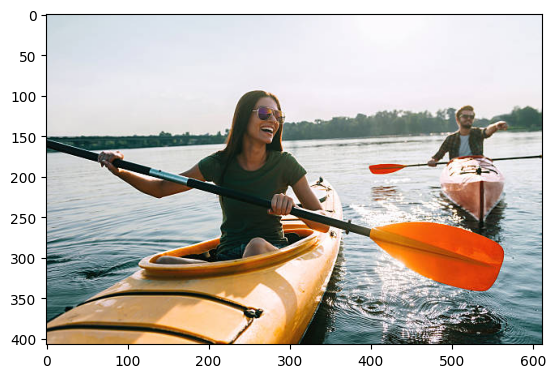

In [11]:
image = cv2.imread('../data/images/istockphoto-610864024-612x612.jpg')
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
plt.imshow(image)

### Initialize Blip2Processor

In [14]:
processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")

In [ ]:
encoding = processor(images=image, text="An Image of ")
for k, _ in encoding.items():
    print(k)

In [32]:
input_ids = torch.tensor(encoding['input_ids'])
pixel_values = torch.from_numpy(np.array(encoding['pixel_values']))

### Download Model

In [34]:
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b")

Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00, 10.71it/s]
